## ***INTRO***

**Personalized PageRank(PPR)** is one of the most widely used proximity measures in graphs. While PageRank quantifies *the importance of vertices overall*, the PPR vector measures ***the importance of vertices w.r.t to a given source vertex $s$***. For instance, a vertex $v$ with a larger PPR value w.r.t. $s$ implies that a random walk starting from $s$ has a higher probability to reach $v$. PPR is used in applications of many fields, such as web search for Internet individuals, user recommendation, community detection and graph partitioning. Although it takes only a few operations to handle any single edge update (insertion/deletion), it is practically inefficient.

for $\approx$ 5000 edges $-$ latency of 2-3 mins


realworld dynamic graphs $\approx$ 7000 tweets generated per second (Twitter)

CPUs and GPUs have shown their great potentials in accelerating the graph applications --> **Parallelised Personalised PageRank** Motivation

### **Challenges with Parrellization:**

 (a) the parallel push, can take more operations,
as it reads stale values of the residual at the beginning of iterations
and then propagates less probability mass from the
frontier vertices (the frontier contains vertices that need to
be pushed in current iteration)

(b) the parallel push needs
to iteratively maintain a vertex frontier and thus results in
synchronization costs to merge duplicate vertices.

### **Our Approach:**

This scheme takes two steps against each single update: (1) restore invariants; (2) perform local pushes. More specifically, each vertex v keeps two values $P_s(v)$ and $R_s(v)$ where $P_s(v)$ is the current estimate to the PPR value of v w.r.t. the source vertex s and $R_s(v)$ is the upper bound on the estimation bias. We call $P_s(v)$ and $R_s(v)$ as the estimate and residual of v respectively. The invariant is maintained for all vertices to ensure the residual is valid. To handle any update, e.g., an edge insertion/deletion, the invariant is first restored which results in change in the residual. Subse- quently, if the residual of a vertex v is over a user-specified threshold, i.e. $ϵ$, the residual is pushed to v’s neighbors.

we implement optimization techniques to practically reduce the number of local push operations (eager propagation) and to efficiently maintain the vertex frontier in parallel by utilizing the monotonicity of the local push process (local duplicate detection)

### **Algorithms Used:**

***Sequential Local Push***:

$Input: (G, P_s, R_s,\epsilon) \\
$

1) While $\max _{u} R_{s}(u)>\epsilon$ ---> $\operatorname{SeQPUSH}(u) \\
$


2) While $\min _{u} R_{s}(u)<-\epsilon$ ---> $\operatorname{SeQPUSH}(u) \\
$

${ return }\left(P_{s}, R_{s}\right)\\
$

procedure $\operatorname{SeQPUSH}(u): \\
P_{s}(u)+=\alpha \cdot R_{s}(u) \\
\forall v \in N_{i n}(u) \text { do }\\
R_{s}(v)+=(1-\alpha) \cdot R_{s}(u) / d_{o u t}(v)\\
R_{s}(u)=0 \\
$

**Parallel Local Push**:

$Input: (G, P_s, R_s,\epsilon) \\
$

1) $F Q=\left\{u \in V \mid \operatorname{PUSHCOND}\left(R_{s}(u), P O S\right)\right\} 
$

While $FQ \neq \emptyset 
$ --> $F Q=\operatorname{PARALLELPUSH}\left(P_{s}, R_{s}, F Q, P O S\right) \\
$


2) $F Q=\left\{u \in V \mid \operatorname{PUSHCOND}\left(R_{s}(u), N E G\right)\right\} 
$

While $FQ \neq \emptyset 
$ --> $F Q=\operatorname{PARALLELPUSH}\left(P_{s}, R_{s}, F Q, N E G\right) 
$

return $(P_s, R_s)$

$ {PUSHCOND }(r, \text { phase })$ --> if phase = $P O S$ return $r>ϵ$ else return $r<-ϵ$ 



$ {PARALLELPUSH }\left(P_{s}, R_{s}, F Q, p h a s e\right)$ --> $S = \emptyset \\  u \in F Q \\ S=S \cup\left(u, R_{s}(u)\right) \\ P_{s}(u)+=\alpha \cdot R_{s}(u) \\ R_{s}(u)=0 \\ Synchronize \\ F Q^{\prime}=\emptyset \\ { parallel for }(u, w) \in S\\ { parallel for }(v, u) \in N_{i n}(u) \\ { ATOMICADD }\left(R_{s}(v),(1-\alpha) \cdot w / d_{o u t}(v)\right) \\ { if PUSHCOND }(v, \text { phase }) then \\ { UNIQUEENQUEUE }\left(F Q^{\prime}, v\right)\\ synchronize \\ return FQ'$






**Updating Residue**:


Input: $\left(G, P_{s}, R_{s}, u, v, o p\right)$

Require: $(u, v, o p)$ is the updating edge with op being the insert/delete operation.

1: procedure $\operatorname{INSERT}(u, v) \\
$
2:$\quad R_{s}(u)+=\frac{(1-\alpha) \cdot P_{s}(v)-P_{s}(u)-\alpha \cdot R_{s}(u)+\alpha \cdot 1_{u=s}}{d_{\text {out }}(u)} \cdot \frac{1}{\alpha}$


3: procedure $\operatorname{DeLETE}(u, v) \\
$
4: $\quad R_{s}(u)-=\frac{(1-\alpha) \cdot P_{s}(v)-P_{s}(u)-\alpha \cdot R_{s}(u)+\alpha \cdot 1_{u=s}}{d_{\text {out }}(u)} \cdot \frac{1}{\alpha}$

**Optimal Parallel Push:**

$
\begin{array}{l}
\text { procedure PUSHCONDLOCAL }\left(r_{p r e}, r_{c u r}, \text { phase }\right) \\
\text { if !PUSHCOND }\left(r_{p r e}, \text { phase }\right) \text { then } \\
\text { if PUSHCOND }\left(r_{c u r}, \text { phase }\right) \text { then } \\
\text { return true } \\
\text { return } f \text { alse } \\
\text { procedure OPTPARALLELPUSH }\left(P_{s}, R_{s}, F Q, p h a s e\right) \\
F Q^{\prime}=\emptyset \\
E=\emptyset \\
\text { parallel for } u \in F Q \\
r_{u} \leftarrow R_{s}(u) \\
E=E \cup\left(u, r_{u}\right) \\
\text { parallel for } v \in N_{i n}(u) \\
\quad i n c=(1-\alpha) \cdot r_{u} / d_{o u t}(v) \\
\quad r_{p r e}=\operatorname{ATOMICADD}\left(R_{s}(v), \text { inc }\right) \\
\quad r_{c u r}=r_{p r e}+i n c \\
\quad \text { if PUSHCONDLOCAL }\left(r_{p r e}, r_{c u r}, p h a s e\right) \text { then } \\
\quad \text { ENQUEUE }\left(F Q^{\prime}, v\right) \\
\text { synchronize } \\
\text { parallel for }\left(u, r_{u}\right) \in E \\
P_{s}(u)+=\alpha \cdot r_{u} \\
R_{s}(u)-=r_{u} \\
\quad \text { if } \operatorname{PUSHCOND}\left(R_{s}(u), p h a s e\right) \text { then } \\
\quad \text { ENQUEUE }\left(F Q^{\prime}, u\right) \\
\text { synchronize } \\
\text { return } F Q^{\prime}
\end{array}
$

### **Complexity of the Algorithm:**

On a worst-case graph, for a uniform random target, the expected time required to maintain PPR estimates at accuracy $\varepsilon$ to that target as $k$ edge updates arrive in a random order is $O(k+k /(n \varepsilon)+\bar{d} / \varepsilon)$. Here $\varepsilon$ is the desired additive error of the estimates, and $\bar{d}$ is the average degree of nodes in the graph. Since a random PPR value is $1 / n$, values smaller than $1 / n$ are not very meaningful. Hence typically $\varepsilon=\Omega(1 / n)$ and our running time is $O(k+\bar{d} / \varepsilon)$. Since $\bar{d} / \varepsilon$ is the expected time required to compute Reverse Push from scratch, we see that our incremental algorithm can maintain estimates after every edge update using $O(1)$ time per update and the time required to compute a single Reverse Push vector.
For the Forward Push algorithm, we show that on an arbitrary undirected graph and arbitrary edge arrival order, for a uniform random source node $s$, the worst-case running time to maintain a PPR vector from that source node is $O(k+k /(n \varepsilon)+1 / \varepsilon)$. Here $\varepsilon$ is a bound on the degree normalized error. Typically $\varepsilon=\Omega(1 / n)$, so this is $O(k+1 / \varepsilon)$. The cost of computing such a PPR vector from scratch is $O(1 / \varepsilon)$ so we again see that the cost to maintain the PPR vector over $k$ updates is $O(1)$ per update plus the cost of computing it once from scratch






## Sequential approach

In [ ]:
!pip3 install mpi4py

     |████████████████████████████████| 2.5 MB 26.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185269 sha256=e2fc50dc8b0acd455be1d334e2bf8838978397639dcb9807e807f4040b1145b3
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import mpi4py as MPI
import numpy as np
from PIL import Image
import random

In [ ]:
# G = np.array([[0, 0, 0, 1],
#              [1, 0, 0, 0],
#              [1, 1, 0, 0],
#              [0, 0, 1, 0]])
# p = np.array([1/2, 1/4, 3/16, 1/16])
# r = np.array([1/16, 0, 0, 1/16])

In [ ]:
# def restore_invariant(G, d, p, r, u, v, op='insert'):
#     out = G.sum(axis=1).reshape(-1)[u]
#     r_new = ((1 - d) * p[v] - p[u] - d * r[u] + d * (u == p.argmax())) / d / out
#     r[u] += r_new if op == 'insert' else - r_new
#     return r

# def sequential_push(G, d, p, r, eps):
#     out = G.sum(axis=1).reshape(-1)
#     def seq_push(u):
#         p[u] += d * r[u]
#         for i in G[:, u].nonzero():
#             if i.size > 0:
#                 v = i[0]
#                 r[v] += (1 - d) * r[u] / out[v]
#         r[u] = 0
#     while max(r) > eps:
#         seq_push(r.argmax())
#     while min(r) < - eps:
#         seq_push(r.argmin())
#     return p, r

In [ ]:
# new_G = G.copy()
# new_G[0, 1] = 1
# d = 0.5

# restore_invariant(G, d, p, r, 0, 1, 'insert')
# sequential_push(G, d, p, r, 0.1)

In [ ]:
# N = 4
# G_zeros = np.zeros((N, N))
# p = np.zeros(N)
# r = np.zeros(N)
# r[0] = 1
# d = 0.5

# edges = []
# for i in range(N):
#   for j in range(N):
#     if G[i, j] == 1:
#       edges.append((i, j))

In [ ]:
# for e in edges:
#   G_zeros[e[0], e[1]] = 1
#   r1 = restore_invariant(G_zeros, d, p, r, e[0], e[1], 'insert')
#   print(f"residuals after restoring invariant are {r1}")
#   p1, r1 = sequential_push(G_zeros, d, p, r, 0.1)
#   print(f"page rank after push is {p1} and residuals are {r1}")

it's the same, as it was on the first place

## Parallelize via MPI

In [ ]:
import os
import csv

In [ ]:
def matrix_to_file(adjacency_matrix, filePath):
  with open(filePath, mode='w') as csv_file:
    fieldnames = range(adjacency_matrix.shape[1])
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(adjacency_matrix.shape[0]):
      row = {j:adjacency_matrix[i, j] for j in range(adjacency_matrix.shape[1])}
      writer.writerow(row)

In [ ]:
from scipy.sparse import rand
from itertools import permutations

In [ ]:
N = 10

In [ ]:
u = []

for a, b in permutations(range(N), 2):
    num = 1 if np.random.rand() > 0.5 else -1
    u.append((a, b, num))

In [ ]:
A = rand(N, N, density=0.2)
A.data[:] = 1
A = A.astype(np.int32).todense()
np.fill_diagonal(A, 0)

matrix_to_file(A, 'matrix.csv')
Updates = np.array(u) #  inserting u -> v (u, v, 1) | deleting u -> v (u, v, -1)
matrix_to_file(Updates, 'updates.csv')

In [ ]:
def matrix_from_file(file):
  with open(file, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    A = []
    for row in csv_reader:
        size = len(row.values())
        A.append([int(row[str(i)]) for i in range(size)])
    return np.array(A)

In [ ]:
matrix_from_file('matrix.csv'), matrix_from_file('updates.csv')

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0]]), array([[ 0,  1,  1],
        [ 0,  2, -1],
        [ 0,  3, -1],
        [ 0,  4, -1],
        [ 0,  5, -1],
        [ 0,  6,  1],
        [ 0,  7,  1],
        [ 0,  8, -1],
        [ 0,  9,  1],
        [ 1,  0,  1],
        [ 1,  2, -1],
        [ 1,  3,  1],
        [ 1,  4,  1],
        [ 1,  5,  1],
        [ 1,  6, -1],
        [ 1,  7, -1],
        [ 1,  8, -1],
        [ 1,  9,  1],
        [ 2,  0,  1],
        [ 2,  1, -1],
        [ 2,  3,  1],
        [ 2,  4, -1],
        [ 2,  5, -1],
        [ 2,  6, -1],
        [ 2,  7,  1],
        [ 2,  8, -1],
        [ 2,  9, -1],
     

In [ ]:
def arrays_to_file(arrays, filePath):
  with open(filePath, 'w') as f:
    for i in range(len(arrays)):
       f.write(" ".join(map(lambda x: str(x), arrays[i])))
       f.write('\n')

In [ ]:
def pagerank_matrix(A):
    G = np.array(A, dtype=np.float)
    p_list = np.sum(G, axis=0)
    
    for i in range(G.shape[0]):
        if p_list[i] != 0:
            G[:, i] /= p_list[i]

    return G

In [ ]:
PM = pagerank_matrix(A)

p = np.sum(PM, axis=1) / PM.shape[0]

upcom_max = np.sum(A, axis=0).max()

eps = 0.1

r = np.array([eps if np.sum(A[:, i]) == upcom_max else 0 for i in range(A.shape[1])])

arrays_to_file([p, r], 'arrays.txt')

In [ ]:
def arrays_from_file(filePath):
  with open(filePath, 'r') as f:
    arrays = []
    for row in f.readlines():
      arrays.append(np.array(list(map(lambda x: float(x), row.split(" ")))))
    return arrays

In [ ]:
arrays_from_file('arrays.txt')

[array([0.        , 0.1       , 0.08333333, 0.03333333, 0.18333333,
        0.05      , 0.03333333, 0.13333333, 0.05      , 0.13333333]),
 array([0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1])]

In [ ]:
%%writefile fq.py
#!/usr/bin/python
from mpi4py import MPI
import numpy as np
import string
import sys

def main(fq_str, p_str, r_str, alpha_str):
    parent = MPI.Comm.Get_parent()
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    fq = list(map(lambda x: int(x), fq_str.split(" ")))
    p = np.array(list(map(lambda x: float(x), p_str.split(" "))))
    r = np.array(list(map(lambda x: float(x), r_str.split(" "))))
    alpha = float(alpha_str)
    
    S = []
    for i in range(len(fq)):
        u = fq[i]
        p[i] += alpha * r[i]
        S.append((u, p[i], r[i]))
        r[i] = 0
    print(f"daughter {rank}: {S}")
    parent.barrier()

    parent.gather(S, root=0)
    parent.Disconnect()

if __name__ == "__main__":
    main(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4])

Writing fq.py


In [ ]:
%%writefile pagerank.py
#!/usr/bin/python

import csv
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from mpi4py import MPI
import numpy as np
import os
from PIL import Image
import random
import sys
import time

def matrix_to_file(adjacency_matrix, filePath):
  with open(filePath, mode='w') as csv_file:
    fieldnames = range(adjacency_matrix.shape[1])
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(adjacency_matrix.shape[0]):
      row = {j:adjacency_matrix[i, j] for j in range(adjacency_matrix.shape[1])}
      writer.writerow(row)

def matrix_from_file(file):
  with open(file, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    A = []
    for row in csv_reader:
        size = len(row.values())
        A.append([int(row[str(i)]) for i in range(size)])
    return np.array(A)

def arrays_to_file(arrays, filePath):
  with open(filePath, 'w') as f:
    for i in range(len(arrays)):
       f.write(" ".join(map(lambda x: str(x), arrays[i])))
       f.write('\n')

def arrays_from_file(filePath):
  with open(filePath, 'r') as f:
    arrays = []
    for row in f.readlines():
      arrays.append(np.array(list(map(lambda x: float(x), row.split(" ")))))
    return arrays

def restore_invariant(G, alpha, p, r, u, v, op='insert'):
    if op == 'insert':
      G[u, v] = 1
    else:
      G[u, v] = 0
    out = G.sum(axis=1).reshape(-1)[u]
    out = 1 if out == 0 else out
    r_new = ((1 - alpha) * p[v] - p[u] - alpha * r[u] + alpha * (u == p.argmax())) / alpha / out
    r[u] += r_new if op == 'insert' else - r_new
    return r

def sequential_push(G, alpha, p, r, eps):
    out = G.sum(axis=1).reshape(-1)
    def seq_push(u):
        p[u] += alpha * r[u]
        for i in G[:, u].nonzero():
            if i.size > 0:
                v = i[0]
                r[v] += (1 - alpha) * r[u] / out[v]
        r[u] = 0
    while max(r) > eps:
        seq_push(r.argmax())
    while min(r) < -eps:
        seq_push(r.argmin())
    return p, r


def parallel_addition(S, FQ, p, r, size, alpha):
    if len(FQ) < 2*size:
        chunk_size = len(FQ)
    chunk_size = len(FQ)//size + 1
    chunks = len(FQ) // chunk_size
    args = []
    for i in range(chunks):
        chunk_head = chunk_size * i
        chunk_tail = chunk_size * (i + 1)
        if chunk_tail > len(FQ):
            chunk_tail = len(FQ)
        fq = FQ[chunk_head:chunk_tail]
        new_p = " ".join(map(lambda x: str(x), p[fq]))
        new_r = " ".join(map(lambda x: str(x), r[fq].astype(str)))
        fq_arg = " ".join(map(lambda x: str(x), fq))
        args.append((fq_arg, new_p, new_r, str(alpha)))
    args = [["fq.py"] + [data[0]] + [data[1]] + [data[2]] + [data[3]] for data in args]
    print(f"number of processes: {args}")
    intercomm = MPI.COMM_SELF.Spawn_multiple([sys.executable]*chunks, args=args, maxprocs=[1]*chunks)
    intercomm.barrier()
    
    results = intercomm.gather(None, root=MPI.ROOT)
    intercomm.Disconnect()
    for proc_result in results:
        for result in proc_result:
            fq_i, p_i, r_i = result
            S.append((fq_i, r_i))
            r[fq_i] = 0
            p[fq_i] = p_i
        
def parallel_push(G, p, r, phase, FQ, alpha, epsilon, size):
    S = []
    parallel_addition(S, FQ, p, r, size, alpha)

    FQ_new = []
    # parallel for (u, v) in S for (v, u) in
    for u, w in S:
        for i in G[:, u].nonzero():
            out = G.sum(axis=1).reshape(-1)
            v = i[0] if i.size > 0 else 1
            # atomic
            r[v] += (1 - alpha) * w / out[v]

            if (r[v] > epsilon if phase == 1 else r[v] < -epsilon):
                FQ_new.append(v)
    #synchronize
    return FQ_new

def get_coords(graph):
    N = graph.shape[0]
    radius = 100
    possible_pos = []
    index = 0
    for i in range(N):
        x0, y0 = 2 * radius, (3 * i + 2) * radius
        possible_pos.append((x0, y0, index))
        index += 1

        for j in range(1, N):
            x, y = (3 * j + 2) * radius, y0
            possible_pos.append((x, y, index))
            index += 1

    possible_pos = np.array(possible_pos)
    mask = np.ones(len(possible_pos), dtype=np.bool_)
    coords = []
    
    for i in range(N):
        x, y, index = random.choice(possible_pos[mask])
        mask[int(index)] = False
        coords.append((x, y))
    return coords

def get_plot(index, original_graph, graph, page_rank, coords):
    N = graph.shape[0]
    page_rank = page_rank / sum(page_rank)
    
    plt.figure(figsize=(20, 10))
    cm = plt.cm.get_cmap('jet')


    dotted = {}

    for i in range(original_graph.shape[0]):
      for j in range(original_graph.shape[1]):
        if original_graph[i,j] != graph[i,j]:
          dotted[(j,i)] = 1


    for i, p in enumerate(coords):
        x1, y1 = p

        plt.scatter(x1, y1, s=1000,
                    zorder=2, vmin=0.,
                    vmax=.3,
                    cmap=cm, c=page_rank[i],
                    edgecolors='black')
        
        plt.annotate(round(page_rank[i], 2),
                     (x1, y1), va = "center",
                     ha="center", color='white')

        for val, v in enumerate(graph[i]):
            if v == 1:
                x2, y2 = coords[val]
                ls_style = '-'
                if (i,val) in dotted:
                  ls_style = '--'
                
                plt.annotate('', xy=(x1, y1),
                    xytext=(x2, y2),
                    arrowprops=
                        dict(arrowstyle='->',
                            color='black',
                            lw=1., ls=ls_style,
                            connectionstyle='angle3',
                            shrinkA=20, shrinkB=20)
                )
            
    plt.axis('off')
    plt.colorbar()
    filename = 'image_' + '{0:08}'.format(index) + '00.png'
    plt.savefig(filename, dpi=200)
    print(f"saved in file {filename}")

def animate(time_delays):
  norm_delays = (np.array(time_delays) / min(time_delays)).astype(int)
  norm_delays = norm_delays - 1 #delays - for example [0, 4, 2]
#   print('delays:', norm_delays)

  #TODO: adding in-between slides:
  # image_100, image_200, image_300 -> image_100, image_200, image_201, image_202, image_203, image_204, image_300, image_301, image_303

  fp_in = "image_*.png"
  fp_out = "pagerank.gif"
  img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
  
  for i, d in enumerate(norm_delays):
    for j in range(d):
        filename = 'image_' + '{0:08}'.format(i) + '{0:02}.png'.format(j + 1)
        imgs[i].save(filename)
        print(filename)

  img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]

#   print('num of images:', len(imgs))
  
  img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)
  for filePath in sorted(glob.glob(fp_in)):
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
  print(f"Animation saved in file {fp_out}")

def main(matrix_file, priority_and_residuals_file, updates_file, alpha_str, epsilon_str):
    world = MPI.COMM_WORLD
    rank = world.Get_rank()
    size = world.Get_size()
    
    A = matrix_from_file(matrix_file)
    p_and_r = arrays_from_file(priority_and_residuals_file)
    updates = matrix_from_file(updates_file)
    p = p_and_r[0]
    r = p_and_r[1]
    alpha = float(alpha_str)
    epsilon = float(epsilon_str)

    coords = get_coords(A)
    
    time_delays = []
    index = 0

    if rank == 0:
        chunks = np.array_split(updates, len(updates) // 3)
        for chunk in chunks:
            A_original = A.copy()
            for i, _ in enumerate(chunk):
                update = chunk[i]
                u = update[0]
                v = update[1]
                op = "insert" if update[2] else "delete"
                restore_invariant(A, alpha, p, r, u, v, op)

            FQ = [i for i,v in enumerate(r) if v > epsilon]
            first_iter = True

            # print(FQ)

            while len(FQ) != 0:
                start = time.time()
                if first_iter:
                    start -= 3
                    first_iter = False
                FQ = parallel_push(A, p, r, 1, FQ, alpha, epsilon, size)
                end = time.time()
                time_delays.append((end - start) / 1000)
                index+=1
                get_plot(index, A_original, A, p, coords)

            FQ = [i for i,v in enumerate(r) if v < -epsilon]
            while len(FQ) != 0:
                start = time.time()
                FQ = parallel_push(A, p, r, -1, FQ, alpha, epsilon, size)
                end = time.time()
                time_delays.append((end - start) / 1000)
                index+=1
                get_plot(index, A_original, A, p, coords)
            
        animate(time_delays)

        # print(time_delays)
        # print(p)
        # print(r)

if __name__ == "__main__":
    main(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])


Overwriting pagerank.py


In [ ]:
!mpirun --allow-run-as-root -np 3 -oversubscribe python3 pagerank.py matrix.csv arrays.txt updates.csv 0.5 0.1

number of processes: [['fq.py', '1', '0.1', '-0.10340136054421771', '0.5']]
daughter 0: [(1, 0.04829931972789115, -0.10340136054421771)]
saved in file image_0000000100.png
number of processes: [['fq.py', '4', '0.18333333333333332', '0.40632653061224494', '0.5']]
daughter 0: [(4, 0.3864965986394558, 0.40632653061224494)]
saved in file image_0000000200.png
number of processes: [['fq.py', '0', '0.0', '0.1057180650037793', '0.5']]
daughter 0: [(0, 0.05285903250188965, 0.1057180650037793)]
saved in file image_0000000300.png
number of processes: [['fq.py', '4', '0.3864965986394558', '0.16906142978453384', '0.5']]
daughter 0: [(4, 0.4710273135317227, 0.16906142978453384)]
saved in file image_0000000400.png
number of processes: [['fq.py', '7', '0.13333333333333333', '-0.11241128117913832', '0.5']]
daughter 0: [(7, 0.07712769274376417, -0.11241128117913832)]
saved in file image_0000000500.png
number of processes: [['fq.py', '9', '0.13333333333333333', '-0.12592404347427127', '0.5']]
daughter 0:

In [ ]:
#TODO:
# - bigger matrix
# - more updates
# - profit: beutiful gif

In [ ]:
def get_coords(graph):
    N = graph.shape[0]
    radius = 100
    possible_pos = []
    index = 0
    for i in range(N):
        x0, y0 = 2 * radius, (3 * i + 2) * radius
        possible_pos.append((x0, y0, index))
        index += 1

        for j in range(1, N):
            x, y = (3 * j + 2) * radius, y0
            possible_pos.append((x, y, index))
            index += 1

    possible_pos = np.array(possible_pos)
    mask = np.ones(len(possible_pos), dtype=np.bool_)
    coords = []
    
    for i in range(N):
        x, y, index = random.choice(possible_pos[mask])
        mask[int(index)] = False
        coords.append((x, y))
    return coords

In [ ]:
def get_plot(graph, page_rank, coords):
    radius = 100
    N = graph.shape[0]
    page_rank = page_rank / sum(page_rank)
    
    plt.figure(figsize=(20, 10))
    cm = plt.cm.get_cmap('jet')

    for i, p in enumerate(coords):
        x1, y1 = p

        plt.scatter(x1, y1, s=1000,
                    zorder=2, vmin=0.,
                    vmax=.2,
                    cmap=cm, c=page_rank[i],
                    edgecolors='black')
        
        plt.annotate(round(page_rank[i], 2),
                     (x1, y1), va = "center",
                     ha="center" )

        for val, v in enumerate(graph[i]):
            if v == 1:
                x2, y2 = coords[val]
                
                plt.annotate('', xy=(x1, y1),
                    xytext=(x2, y2),
                    arrowprops=
                        dict(arrowstyle='->',
                            color='black',
                            lw=1., ls='-',
                            connectionstyle='angle3',
                            shrinkA=20, shrinkB=20)
                )
            
    plt.axis('off')
    plt.colorbar()
    # filename = 'image_' + '{0:08}'.format(index) + '00.png'
    # plt.savefig(filename, dpi=200)
    # print(f"saved in file {filename}")

In [ ]:
def animate(time_delays):
  norm_delays = (time_delays / min(time_delays)).astype(int)
  norm_delays = norm_delays - 1
  print(norm_delays)

  fp_in = "image_*.png"
  fp_out = "pagerank.gif"
  img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
  img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)
  for filePath in sorted(glob.glob(fp_in)):
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
  print(f"Animation saved in file {fp_out}")

In [ ]:
N = 10

A = np.random.randint(2, size=(N, N), dtype=int)
np.fill_diagonal(A, 0)

In [ ]:
coords = get_coords(A)

In [ ]:
p = np.random.rand(N)
p

array([0.58003679, 0.96365352, 0.3499864 , 0.56122476, 0.06732612,
       0.30359691, 0.23381801, 0.1679025 , 0.39658603, 0.84285281])

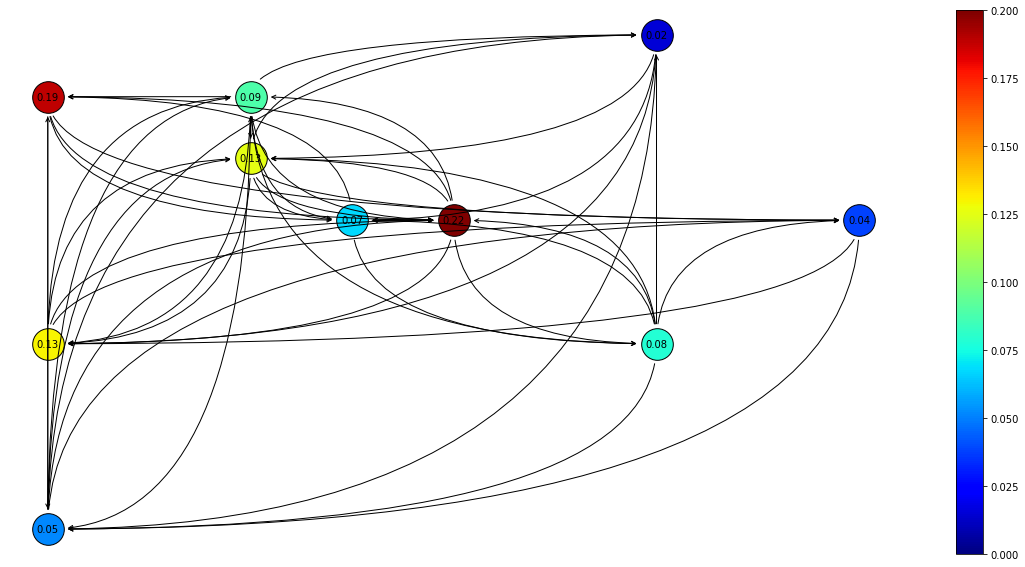

In [ ]:
get_plot(A, p, coords)

Traceback (most recent call last):
  File "pagerank.py", line 274, in <module>
    main(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])
  File "pagerank.py", line 267, in main
    animate(time_delays)
  File "pagerank.py", line 185, in animate
    norm_delays = (np.array(time_delays) / min(time_delays)).astype(int)
ValueError: min() arg is an empty sequence
-------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code.. Per user-direction, the job has been aborted.
-------------------------------------------------------
--------------------------------------------------------------------------
mpirun detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[14546,1],0]
  Exit code:    1
--------------------------------------------------------------------------
100
Traceback (most recent call last):
  Fi

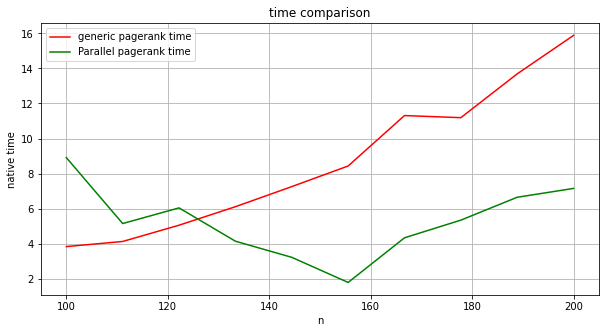

In [ ]:
import time
u = []

for a, b in permutations(range(N), 2):
    num = 1 if np.random.rand() > 0.5 else -1
    u.append((a, b, num))
def power_method(A, x0, n_iter): # 5 pts
    n = A.shape[0]
    res = []
    for i in range(n_iter):
        x0 = A @ x0
        x0 /= np.linalg.norm(x0, 2)
        
        l = np.dot(A @ x0, x0)
        res.append(np.linalg.norm(A @ x0 - l * x0, 2))
        
    # enter your code here
    return x0, l, res
native_time = []
our_time = []
for n in (np.linspace(100,200,10)).astype(int):

  N = n

  A = rand(N, N, density=0.2)
  A.data[:] = 1
  A = A.astype(np.int32).todense()
  np.fill_diagonal(A, 0)

  matrix_to_file(A, 'matrix.csv')
  Updates = np.array(u) #  inserting u -> v (u, v, 1) | deleting u -> v (u, v, -1)
  matrix_to_file(Updates, 'updates.csv')

  matrix_from_file('matrix.csv'), matrix_from_file('updates.csv')


  PM = pagerank_matrix(A)

  p = np.sum(PM, axis=1) / p.shape[0]

  upcom_max = np.sum(A, axis=0).max()

  
  x0 = rand(N,N, density = 0.2)
  x0.data[:] = 1

  z1 = time.time()

  _, l, res = power_method(A, x0=x0, n_iter=1000)
  eps = 0.1

  r = np.array([eps if np.sum(A[:, i]) == upcom_max else 0 for i in range(A.shape[1])])

  z2 = time.time()

  native_time.append(z2-z1)

  arrays_to_file([p, r], 'arrays.txt')

  z3 = time.time()

  !mpirun --allow-run-as-root -np 4 -oversubscribe python3 pagerank.py matrix.csv arrays.txt updates.csv 0.5 0.1

  z4 = time.time()
  our_time.append(z4-z3)

  print(n)


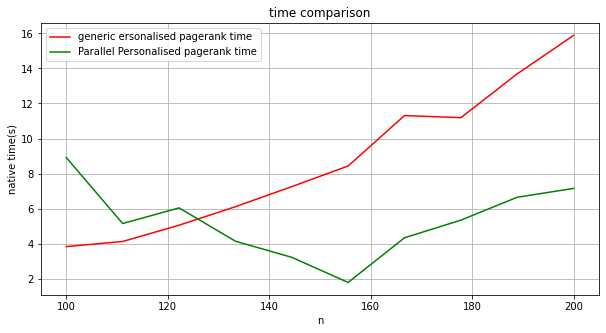

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(np.linspace(100,200,10), native_time, color = 'r', label = 'generic ersonalised pagerank time')
plt.plot(np.linspace(100,200,10), our_time, color = 'g', label = 'Parallel Personalised pagerank time')

plt.xlabel('n')
plt.ylabel('native time(s)')

plt.legend()
plt.grid()
 
plt.title('time comparison')
 
plt.show()

In [ ]:
from IPython.display import Image as Img

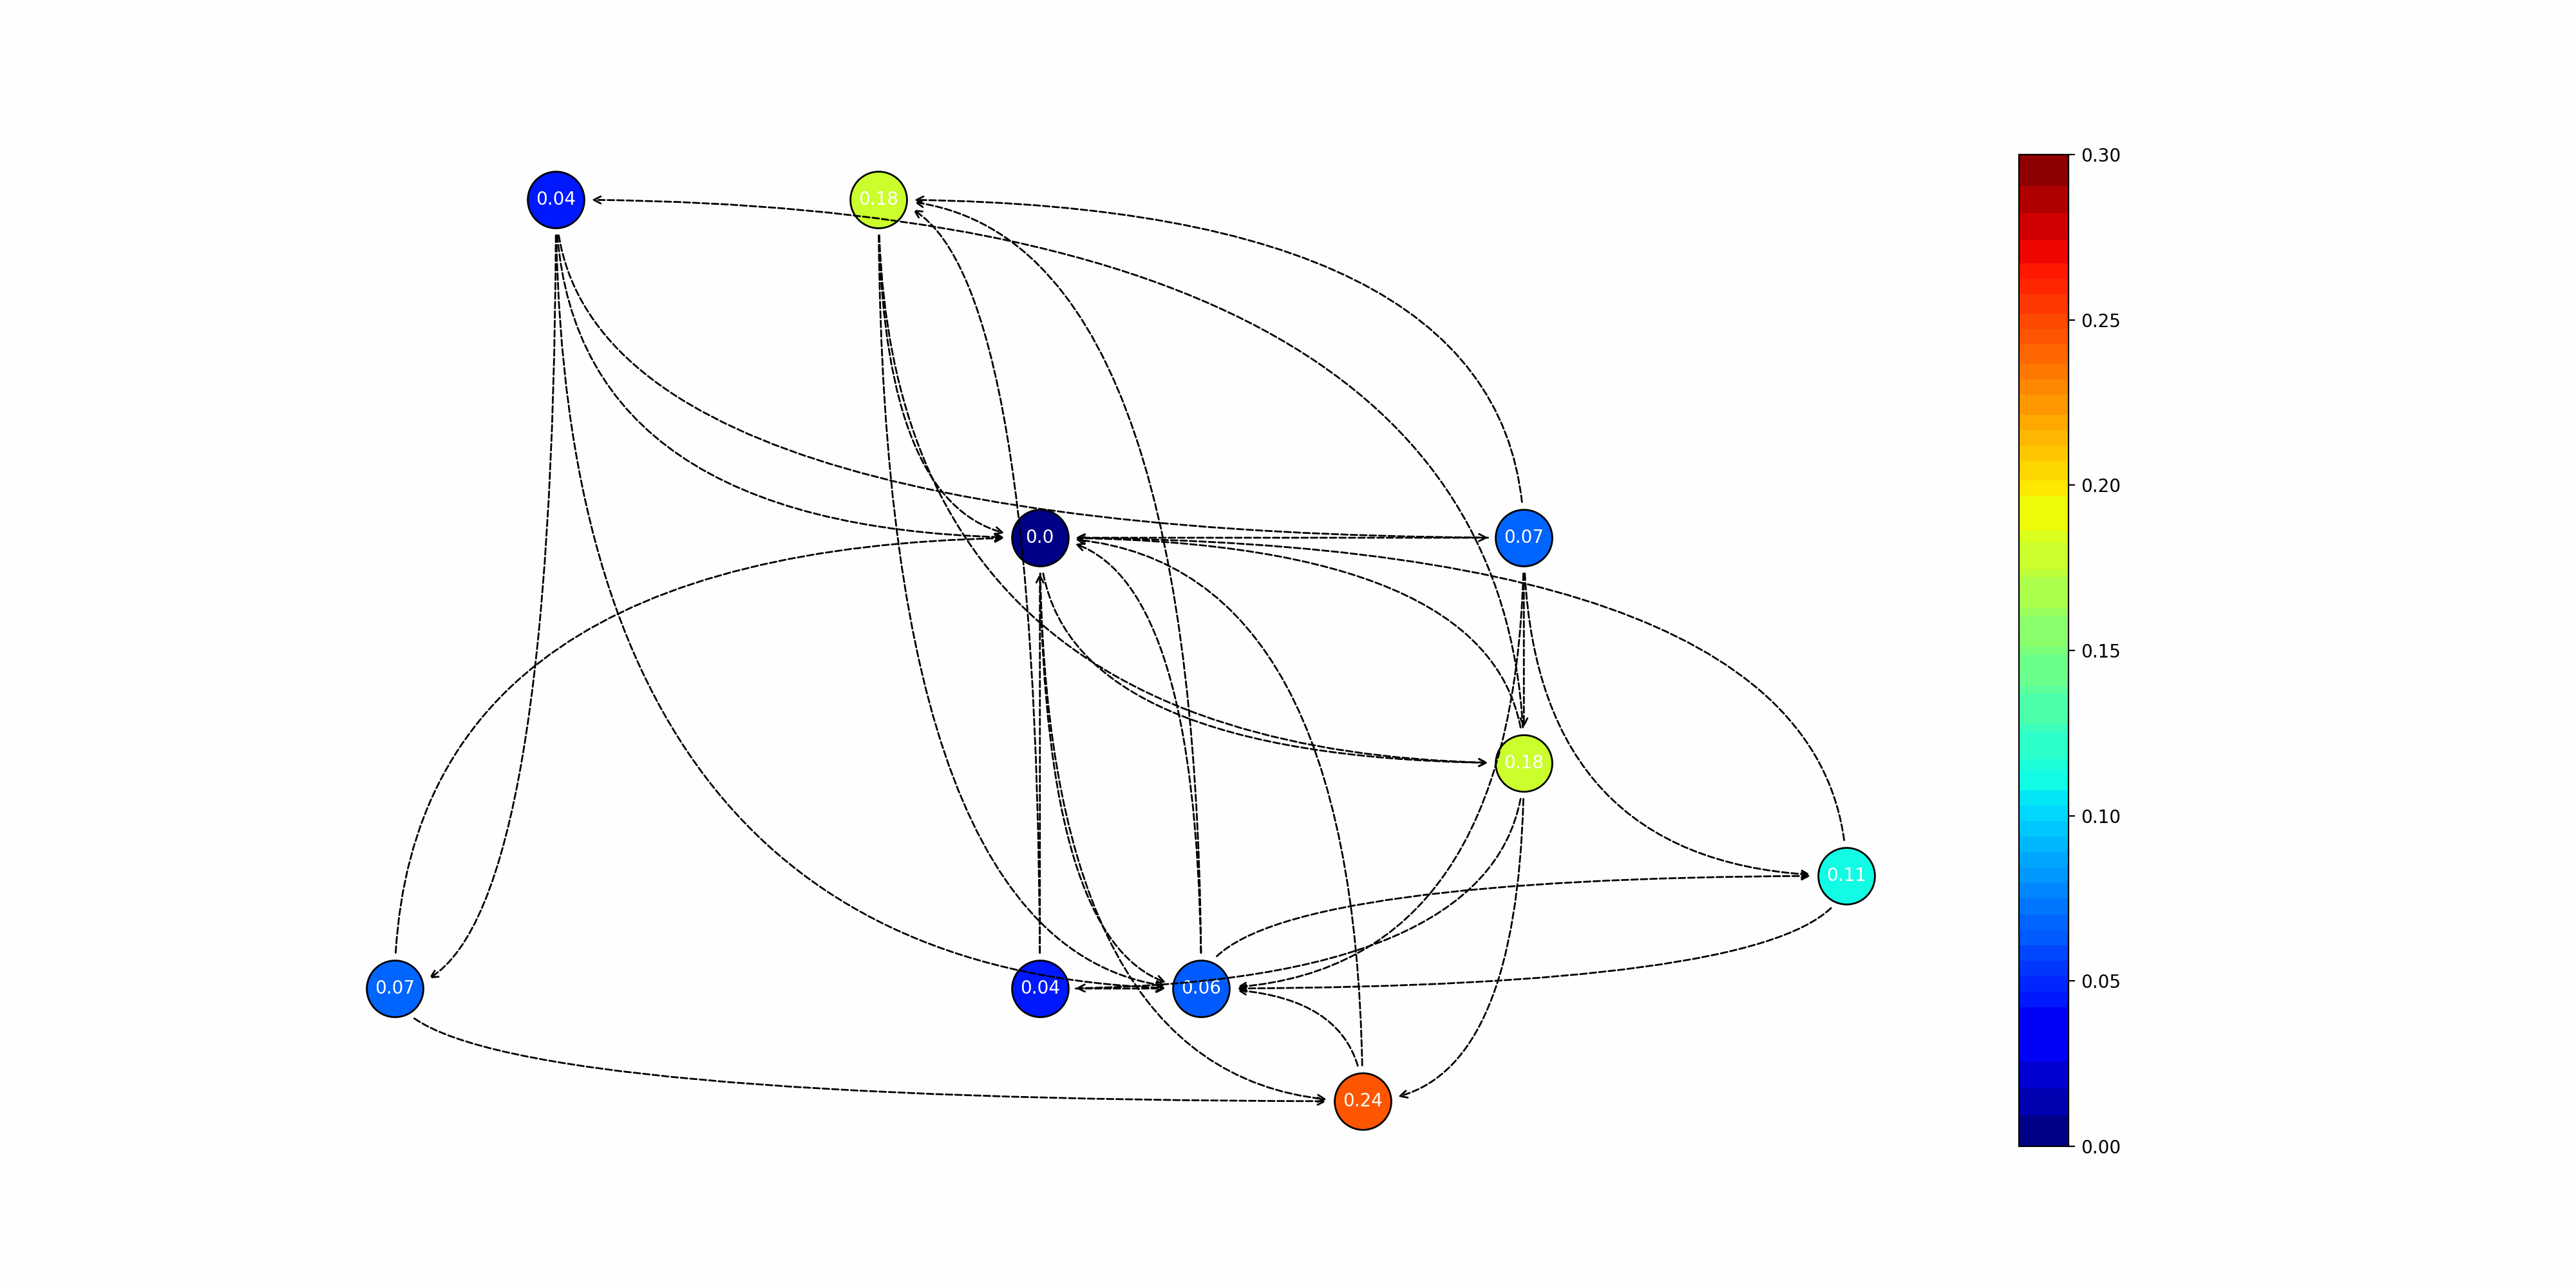

In [ ]:
Img(open('pagerank_dick.gif','rb').read())